### Import Libraries and Read Data

In [55]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plt.rcParams['figure.figsize'] = [20, 5]
from IPython import display
from ipywidgets import interact, widgets
from scipy import optimize


## Read Data for Cases, Deaths and Recoveries
ConfirmedCases_raw=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
Deaths_raw=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
Recoveries_raw=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [56]:
ConfirmedCases_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,47,48,50,50,50,53,59,70,75,82
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,360,420,461,502,511,581,639,639,701,773
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,117,130,138,150,150,160,178,178,200,212
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,50,83,93,99,117,129,149,149,197,238


In [57]:
### Melt the dateframe into the right shape and set index
def cleandata(df_raw):
    df_cleaned=df_raw.melt(id_vars=['Province/State','Country/Region','Lat','Long'],value_name='Cases',var_name='Date')
    df_cleaned=df_cleaned.set_index(['Country/Region','Province/State','Date'])
    return df_cleaned 

### Get Countrywise Data
def countrydata(df_cleaned,oldname,newname):
    df_country=df_cleaned.groupby(['Country/Region','Date'])['Cases'].sum().reset_index()
    df_country=df_country.set_index(['Country/Region','Date'])
    df_country.index=df_country.index.set_levels([df_country.index.levels[0], pd.to_datetime(df_country.index.levels[1])])
    df_country=df_country.sort_values(['Country/Region','Date'],ascending=True)
    df_country=df_country.rename(columns={oldname:newname})
    return df_country

### Get DailyData from Cumulative sum
def dailydata(dfcountry,oldname,newname):
    dfcountrydaily=dfcountry.groupby(level=0).diff().fillna(0)
    dfcountrydaily=dfcountrydaily.rename(columns={oldname:newname})
    return dfcountrydaily

In [58]:
# Clean all datasets
ConfirmedCases=cleandata(ConfirmedCases_raw)
Deaths=cleandata(Deaths_raw)
Recoveries=cleandata(Recoveries_raw)

In [59]:
ConfirmedCases.head()

,,,Lat,Long,Cases
Country/Region,Province/State,Date,,,
Thailand,NaN,1/22/20,15.0000,101.0000,2
Japan,NaN,1/22/20,36.0000,138.0000,2
Singapore,NaN,1/22/20,1.2833,103.8333,0
Nepal,NaN,1/22/20,28.1667,84.2500,0
Malaysia,NaN,1/22/20,2.5000,112.5000,0


In [60]:
# Get countrywise data
ConfirmedCasesCountry=countrydata(ConfirmedCases,'Cases','Total Confirmed Cases')
DeathsCountry=countrydata(Deaths,'Cases','Total Deaths')
RecoveriesCountry=countrydata(Recoveries,'Cases','Total Recoveries')

In [61]:
# Get Daily Data
NewCasesCountry=dailydata(ConfirmedCasesCountry,'Total Confirmed Cases','Daily New Cases')
NewDeathsCountry=dailydata(DeathsCountry,'Total Deaths','Daily New Deaths')
NewRecoveriesCountry=dailydata(RecoveriesCountry,'Total Recoveries','Daily New Recoveries')

In [62]:
CountryConsolidated=pd.merge(ConfirmedCasesCountry,NewCasesCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,NewDeathsCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,DeathsCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,RecoveriesCountry,how='left',left_index=True,right_index=True)
CountryConsolidated=pd.merge(CountryConsolidated,NewRecoveriesCountry,how='left',left_index=True,right_index=True)
CountryConsolidated['Active Cases']=CountryConsolidated['Total Confirmed Cases']-CountryConsolidated['Total Deaths']-CountryConsolidated['Total Recoveries']
CountryConsolidated['Share of Recoveries - Closed Cases']=np.round(CountryConsolidated['Total Recoveries']/(CountryConsolidated['Total Recoveries']+CountryConsolidated['Total Deaths']),2)
CountryConsolidated['Death to Cases Ratio']=np.round(CountryConsolidated['Total Deaths']/CountryConsolidated['Total Confirmed Cases'],3)


In [82]:
CountryConsolidated.reset_index().groupby('Date').sum()

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-01-22,555,0.0,0.0,17,28,0.0,510,0.62,0.031
2020-01-23,653,98.0,1.0,18,30,2.0,605,0.62,0.028
2020-01-24,941,288.0,8.0,26,36,6.0,879,0.58,0.028
2020-01-25,1434,493.0,16.0,42,39,3.0,1353,0.48,0.030
2020-01-26,2118,684.0,14.0,56,52,13.0,2010,2.47,0.027
2020-01-27,2927,809.0,26.0,82,61,9.0,2784,2.41,0.029
2020-01-28,5578,2651.0,49.0,131,107,46.0,5340,2.44,0.024
2020-01-29,6166,588.0,2.0,133,126,19.0,5907,2.47,0.022
2020-01-30,8234,2068.0,38.0,171,143,17.0,7920,3.44,0.021


In [83]:
GlobalTotals=CountryConsolidated.reset_index().groupby('Date').sum()
GlobalTotals['Share of Recoveries - Closed Cases']=np.round(GlobalTotals['Total Recoveries']/(GlobalTotals['Total Recoveries']+GlobalTotals['Total Deaths']),2)
GlobalTotals['Death to Cases Ratio']=np.round(GlobalTotals['Total Deaths']/GlobalTotals['Total Confirmed Cases'],3)
GlobalTotals.tail(2)

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-03-13,145193,16850.0,684.0,5404,70251,1927.0,69538,0.93,0.037
2020-03-14,156102,10909.0,415.0,5819,72624,2373.0,77659,0.93,0.037


###  Cases Worldwide by Status: Total Confirmed, Active, Deaths, Recoveries

In [84]:
GlobalTotals.iloc[-1]

Total Confirmed Cases                 156102.000
Daily New Cases                        10909.000
Daily New Deaths                         415.000
Total Deaths                            5819.000
Total Recoveries                       72624.000
Daily New Recoveries                    2373.000
Active Cases                           77659.000
Share of Recoveries - Closed Cases         0.930
Death to Cases Ratio                       0.037
Name: 2020-03-14 00:00:00, dtype: float64

In [65]:
total_death = GlobalTotals.iloc[-1]['Total Deaths']
total_recoveries = GlobalTotals.iloc[-1]['Total Recoveries']
total_closed = total_death + total_recoveries

In [66]:
total_death / total_closed

0.0741812526292977

In [97]:
plt.style.use('seaborn-dark')

In [70]:
chartcol='red'
fig = make_subplots(rows=3, cols=2,shared_xaxes=True,
                    specs=[[{}, {}],[{},{}],
                       [{"colspan": 2}, None]],
                    subplot_titles=('Total Confirmed Cases','Active Cases','Deaths','Recoveries','Death to Cases Ratio'))
fig.add_trace(go.Scatter(x=GlobalTotals.index,y=GlobalTotals['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Confirmed Cases',
                         line=dict(color=chartcol,width=2)),
                         row=1,col=1)
fig.add_trace(go.Scatter(x=GlobalTotals.index,y=GlobalTotals['Active Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                         row=1,col=2)
fig.add_trace(go.Scatter(x=GlobalTotals.index,y=GlobalTotals['Total Deaths'],
                         mode='lines+markers',
                         name='Deaths',
                         line=dict(color=chartcol,width=2)),
                         row=2,col=1)
fig.add_trace(go.Scatter(x=GlobalTotals.index,y=GlobalTotals['Total Recoveries'],
                         mode='lines+markers',
                         name='Recoveries',
                         line=dict(color=chartcol,width=2)),
                         row=2,col=2)
fig.add_trace(go.Scatter(x=GlobalTotals.index,y=GlobalTotals['Death to Cases Ratio'],
                         mode='lines+markers',
                         line=dict(color=chartcol,width=2)),
                         row=3,col=1)
fig.update_layout(showlegend=False)

### Cases by Region (Inside or Outside China)

In [85]:
#CountryConsolidated['location']=np.where(CountryConsolidated['Country/Region']=='Mainland China','Mainland China','Outside China')
locdata=CountryConsolidated.reset_index()
locdata['location']=np.where(locdata['Country/Region']=='China','China','Outside China')
locdata.head()

,Country/Region,Date,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio,location
0,Afghanistan,2020-01-22,0,0.0,0.0,0,0,0.0,0,NaN,NaN,Outside China
1,Afghanistan,2020-01-23,0,0.0,0.0,0,0,0.0,0,NaN,NaN,Outside China
2,Afghanistan,2020-01-24,0,0.0,0.0,0,0,0.0,0,NaN,NaN,Outside China
3,Afghanistan,2020-01-25,0,0.0,0.0,0,0,0.0,0,NaN,NaN,Outside China
4,Afghanistan,2020-01-26,0,0.0,0.0,0,0,0.0,0,NaN,NaN,Outside China


In [86]:
# Cases by Region (inside or Outside China)
TotalCasesLoc=CountryConsolidated.reset_index()
TotalCasesLoc.head()
TotalCasesLoc['Location']=np.where(TotalCasesLoc['Country/Region']=='China','China','Outside China')
TotalCasesLocaggregated=TotalCasesLoc.groupby(['Location','Date'])['Active Cases'].sum().reset_index()
ActiveCasesChina=TotalCasesLocaggregated[TotalCasesLocaggregated.loc[:,'Location']=='China']
ActiveCasesExcludingChina=TotalCasesLocaggregated[TotalCasesLocaggregated.loc[:,'Location']!='China']
ActiveCasesUS=TotalCasesLocaggregated[TotalCasesLocaggregated.loc[:,'Location']=='US']
ActiveCasesColombia=TotalCasesLocaggregated[TotalCasesLocaggregated.loc[:,'Location']=='Colombia']
ActiveCasesExcludingChina.tail(15)

,Location,Date,Active Cases
91,Outside China,2020-02-29,6089
92,Outside China,2020-03-01,7759
93,Outside China,2020-03-02,9251
94,Outside China,2020-03-03,11588
95,Outside China,2020-03-04,13294
96,Outside China,2020-03-05,15508
97,Outside China,2020-03-06,18757
98,Outside China,2020-03-07,21746
99,Outside China,2020-03-08,24964
100,Outside China,2020-03-09,28146


In [87]:
fig = make_subplots(rows=1, cols=2,shared_xaxes=True,
                   subplot_titles=('Active Cases in China','Active Cases Excluding China'))
fig.add_trace(go.Scatter(x=ActiveCasesChina['Date'],y=ActiveCasesChina['Active Cases'],
                         mode='lines+markers',
                         name='New Cases',
                         line=dict(color=chartcol,width=2)),
                         row=1,col=1)
fig.add_trace(go.Scatter(x=ActiveCasesExcludingChina['Date'],y=ActiveCasesExcludingChina['Active Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                         row=1,col=2)
fig.update_layout(showlegend=False)

### Cases by Country

In [88]:
def plotcountry(Country):
    fig = make_subplots(rows=3, cols=2,shared_xaxes=True,
                    specs=[[{}, {}],[{},{}],
                       [{"colspan": 2}, None]],
                    subplot_titles=('Total Confirmed Cases','Active Cases','Deaths','Recoveries','Death to Cases Ratio'))
    fig.add_trace(go.Scatter(x=CountryConsolidated.loc[Country].index,y=CountryConsolidated.loc[Country,'Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Confirmed Cases',
                         line=dict(color=chartcol,width=2)),
                         row=1,col=1)
    fig.add_trace(go.Scatter(x=CountryConsolidated.loc[Country].index,y=CountryConsolidated.loc[Country,'Active Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                         row=1,col=2)
    fig.add_trace(go.Scatter(x=CountryConsolidated.loc[Country].index,y=CountryConsolidated.loc[Country,'Total Deaths'],
                         mode='lines+markers',
                         name='Total Deaths',
                         line=dict(color=chartcol,width=2)),
                         row=2,col=1)
    fig.add_trace(go.Scatter(x=CountryConsolidated.loc[Country].index,y=CountryConsolidated.loc[Country,'Total Recoveries'],
                         mode='lines+markers',
                         name='Total Recoveries',
                         line=dict(color=chartcol,width=2)),
                         row=2,col=2)
    fig.add_trace(go.Scatter(x=CountryConsolidated.loc[Country].index,y=CountryConsolidated.loc[Country,'Death to Cases Ratio'],
                         mode='lines+markers',
                         name='Death to Cases Ratio',
                         line=dict(color=chartcol,width=2)),
                         row=3,col=1)
    fig.update_layout(showlegend=False)
    
    return fig
CountriesList=['Germany','Italy','US','Australia','Pakistan','Iran','South Korea','Japan','Netherlands','US', 'Colombia']
interact(plotcountry, Country=widgets.Dropdown(options=CountriesList))

<function __main__.plotcountry(Country)>

### Cumulative Data by Country

In [89]:
max_index=CountryConsolidated.reset_index()['Date'].max()
CumulativeCountryData=CountryConsolidated.reset_index().set_index('Date').loc[max_index].set_index('Country/Region')
top10countriesbycases=CumulativeCountryData['Total Confirmed Cases'].sort_values(ascending=False).head(10).index.tolist()
top10countriesbycasesexclChina=CumulativeCountryData[~CumulativeCountryData.index.isin(['China','Others'])]['Total Confirmed Cases'].sort_values(ascending=False).head(10).index.tolist()
top10countriescumulative=CumulativeCountryData.loc[top10countriesbycases]
top10countriescumulativexclChina=CumulativeCountryData.loc[top10countriesbycasesexclChina]

In [90]:
CumulativeCountryData

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Country/Region,,,,,,,,,
Afghanistan,11,4.0,0.0,0,0,0.0,11,NaN,0.000
Albania,38,5.0,0.0,1,0,0.0,37,0.00,0.026
Algeria,37,11.0,1.0,3,12,4.0,22,0.80,0.081
Andorra,1,0.0,0.0,0,1,1.0,0,1.00,0.000
Antigua and Barbuda,1,0.0,0.0,0,0,0.0,1,NaN,0.000
...,...,...,...,...,...,...,...,...,...
United Kingdom,1143,342.0,13.0,21,19,0.0,1103,0.48,0.018
Uruguay,4,4.0,0.0,0,0,0.0,4,NaN,0.000
Venezuela,2,2.0,0.0,0,0,0.0,2,NaN,0.000


In [91]:
fig = go.Figure(go.Bar(x=top10countriescumulativexclChina.index, y=top10countriescumulativexclChina['Total Confirmed Cases'],
                      text=top10countriescumulativexclChina['Death to Cases Ratio'],
            textposition='outside'))
fig.update_layout(title_text='Top countries by Cases and their Death Rates - Excluding China',yaxis_title='Total Cases')

### Total Cases by number of days since 'Outbreak'

In [92]:
### First Cases
ItalyFirstCase=CountryConsolidated.loc['Italy']['Total Confirmed Cases'].reset_index().set_index('Date')
SKFirstCase=CountryConsolidated.loc['Korea, South']['Total Confirmed Cases'].reset_index().set_index('Date')
IranFirstCase=CountryConsolidated.loc['Iran']['Total Confirmed Cases'].reset_index().set_index('Date')
GermanyFirstCase=CountryConsolidated.loc['Germany']['Total Confirmed Cases'].reset_index().set_index('Date')
SingaporeFirstCase=CountryConsolidated.loc['Singapore']['Total Confirmed Cases'].reset_index().set_index('Date')
USFirstCase=CountryConsolidated.loc['US']['Total Confirmed Cases'].reset_index().set_index('Date')
ColombiaFirstCase=CountryConsolidated.loc['Colombia']['Total Confirmed Cases'].reset_index().set_index('Date')

### Growth
ItalyGrowth=ItalyFirstCase[ItalyFirstCase.ne(0)].dropna().reset_index()
SKGrowth=SKFirstCase[SKFirstCase.ne(0)].dropna().reset_index()
IranGrowth=IranFirstCase[IranFirstCase.ne(0)].dropna().reset_index()
GermanyGrowth=GermanyFirstCase[GermanyFirstCase.ne(0)].dropna().reset_index()
SingaporeGrowth=SingaporeFirstCase[SingaporeFirstCase.ne(0)].dropna().reset_index()
USGrowth=USFirstCase[USFirstCase.ne(0)].dropna().reset_index()
ColombiaGrowth=ColombiaFirstCase[ColombiaFirstCase.ne(0)].dropna().reset_index()

### Italy Growth Last 30 days


In [93]:
ItalyGrowth.tail(30)

,Date,Total Confirmed Cases
14,2020-02-14,3.0
15,2020-02-15,3.0
16,2020-02-16,3.0
17,2020-02-17,3.0
18,2020-02-18,3.0
19,2020-02-19,3.0
20,2020-02-20,3.0
21,2020-02-21,20.0
22,2020-02-22,62.0
23,2020-02-23,155.0


### US Growth Last 30 days


In [94]:
USGrowth.tail(30)

,Date,Total Confirmed Cases
23,2020-02-14,13
24,2020-02-15,13
25,2020-02-16,13
26,2020-02-17,13
27,2020-02-18,13
28,2020-02-19,13
29,2020-02-20,13
30,2020-02-21,15
31,2020-02-22,15
32,2020-02-23,15


In [95]:
fig = make_subplots(rows=3, cols=2,shared_xaxes=True,
                   subplot_titles=('Italy','Iran','Korea, South','Germany', 'US', 'Colombia'))

fig.update_xaxes(title_text="Number of Days since Outbreak", row=2, col=1)

fig.update_xaxes(title_text="Number of Days since Outbreak", row=2, col=2)

fig.add_trace(go.Scatter(x=ItalyGrowth.index,y=ItalyGrowth['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                          row=1,col=1)
fig.add_trace(go.Scatter(x=IranGrowth.index,y=IranGrowth['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                          row=1,col=2)
                           
fig.add_trace(go.Scatter(x=SKGrowth.index,y=SKGrowth['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                          row=2,col=1)    
                           
fig.add_trace(go.Scatter(x=GermanyGrowth.index,y=GermanyGrowth['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                          row=2,col=2)  
fig.add_trace(go.Scatter(x=USGrowth.index,y=USGrowth['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                          row=3,col=1)  
fig.add_trace(go.Scatter(x=ColombiaGrowth.index,y=ColombiaGrowth['Total Confirmed Cases'],
                         mode='lines+markers',
                         name='Active Cases',
                         line=dict(color=chartcol,width=2)),
                          row=3,col=2)  
fig.update_layout(showlegend=False,title = 'Active Cases')

In [103]:
# Cases by Region (inside or Outside China)
TotalCasesLoc=CountryConsolidated.reset_index()
TotalCasesLoc.head()
TotalCasesLoc['Location']=np.where(TotalCasesLoc['Country/Region']=='Mainland China','Mainland China','Outside China')
TotalCasesLocaggregated=TotalCasesLoc.groupby(['Location','Date'])['Total Confirmed Cases'].sum().reset_index()
TotalCasesLocaggregated['Projected Infections'] = TotalCasesLocaggregated['Total Confirmed Cases'] * 10
TotalCasesLocaggregated.tail(5)

,Location,Date,Total Confirmed Cases,Projected Infections
48,Outside China,2020-03-10,118592,1185920
49,Outside China,2020-03-11,125865,1258650
50,Outside China,2020-03-12,128343,1283430
51,Outside China,2020-03-13,145193,1451930
52,Outside China,2020-03-14,156102,1561020


## Some Experimenting

In [116]:
# Cases by Region (inside or Outside China)
TotalCasesLoc=CountryConsolidated.reset_index()
TotalCasesLoc.head()
TotalCasesLoc['Location']=np.where(TotalCasesLoc['Country/Region']=='Mainland China','Mainland China','Outside China')
TotalCasesLocaggregated=TotalCasesLoc.groupby(['Location','Date'])['Total Confirmed Cases'].sum().reset_index()
TotalCasesLocaggregated['Projected Infections'] = TotalCasesLocaggregated['Total Confirmed Cases'] * 10
TotalCasesLocaggregated.tail(15)

,Location,Date,Total Confirmed Cases,Projected Infections
38,Outside China,2020-02-29,86011,860110
39,Outside China,2020-03-01,88369,883690
40,Outside China,2020-03-02,90306,903060
41,Outside China,2020-03-03,92840,928400
42,Outside China,2020-03-04,95120,951200
43,Outside China,2020-03-05,97882,978820
44,Outside China,2020-03-06,101784,1017840
45,Outside China,2020-03-07,105821,1058210
46,Outside China,2020-03-08,109795,1097950
47,Outside China,2020-03-09,113561,1135610


In [117]:
GlobalTotals.iloc[-1]

Total Confirmed Cases                 156102.000
Daily New Cases                        10909.000
Daily New Deaths                         415.000
Total Deaths                            5819.000
Total Recoveries                       72624.000
Daily New Recoveries                    2373.000
Active Cases                           77659.000
Share of Recoveries - Closed Cases         0.930
Death to Cases Ratio                       0.037
Name: 2020-03-14 00:00:00, dtype: float64

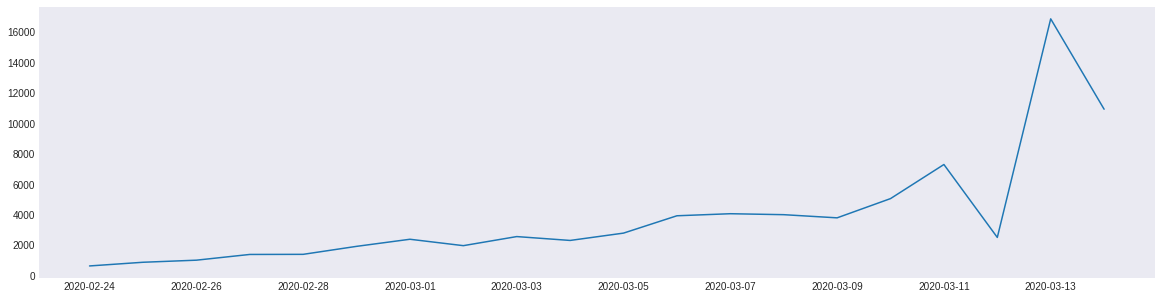

In [106]:
plt.plot(GlobalTotals.iloc[-20:]['Daily New Cases'])

In [107]:
var_range = np.arange(0.0,0.6,0.1)
var_range

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])

In [108]:
df = TotalCasesLocaggregated.set_index('Date')
y_data = df['Total Confirmed Cases'].values
daily_new_cases = GlobalTotals.iloc[-1]['Daily New Cases']

def logistic(x, a, b, c):
     y = c / (1 + np.exp(-b*(x-a)))
     return y

var_params = []
var_dict = {}
for variance in var_range:
    y = y_data.copy()
    #y[-1] = y[-1] * (1 + variance)
    y = np.append(y, y[-1] + daily_new_cases * (1 + variance))
    x = np.array(range(len(y)))
    params, params_covariance = optimize.curve_fit(logistic, x, y, p0=[50, 0.1, 1000000])
    var_dict[variance] = params
    var_params.append(params)
    print(params)

[3.49814448e+01 7.67388948e-02 1.70922416e+05]
[3.51943197e+01 7.63305859e-02 1.72149399e+05]
[3.54115997e+01 7.59218859e-02 1.73409113e+05]
[3.56334231e+01 7.55127902e-02 1.74702909e+05]
[3.5859933e+01 7.5103295e-02 1.7603221e+05]
[3.60912793e+01 7.46933952e-02 1.77398521e+05]


(737476.0, 737507.9587231183)

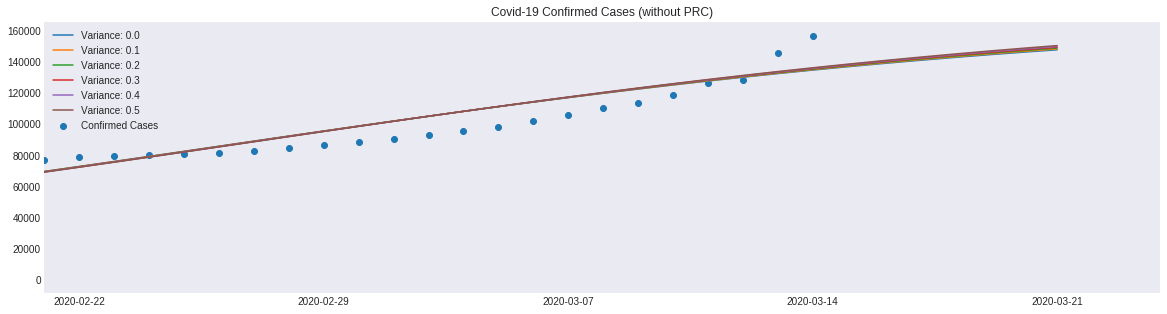

In [109]:
rg = np.array(range(60))
dr1 = pd.date_range(df.index[0], periods=60)
dr2 = pd.date_range(df.index[0], periods=len(df.index))
for variance in var_dict.keys():
    fit_params = var_dict[variance]
    plt.plot(dr1, logistic(rg, *fit_params), label='Variance: {}'.format(round(variance, 3)))
plt.scatter(dr2, y_data, label='Confirmed Cases')
plt.legend(loc='best')
plt.title('Covid-19 Confirmed Cases (without PRC)')
plt.xlim(left=df.index[30])

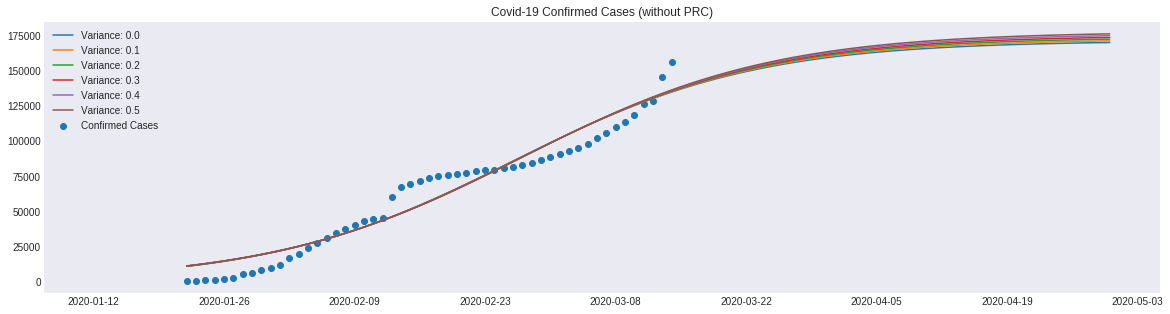

In [110]:
rg = np.array(range(100))
dr1 = pd.date_range(df.index[0], periods=100)
dr2 = pd.date_range(df.index[0], periods=len(df.index))
plt.scatter(dr2, y_data, label='Confirmed Cases')
for variance in var_dict.keys():
    fit_params = var_dict[variance]
    plt.plot(dr1, logistic(rg, *fit_params), label='Variance: {}'.format(round(variance, 2)))
plt.legend(loc='best')
plt.title('Covid-19 Confirmed Cases (without PRC)')

In [112]:
scenarios = [1, 2, 5, 10]

In [113]:
df = TotalCasesLocaggregated.set_index('Date')
x_data = np.array(range(len(df.index)))
y_data = df['Total Confirmed Cases'].values

def logistic(x, a, b, c):
     y = c / (1 + np.exp(-b*(x-a)))
     return y

var_params = []
var_dict = {}
for scen in scenarios:
    y = y_data.copy() * scen
    params, params_covariance = optimize.curve_fit(logistic, x_data, y, p0=[100, 0.1, 400000])
    var_dict[scen] = params
    var_params.append(params)
    print(params)

[2.92512138e+01 9.18347738e-02 1.40253374e+05]
[2.92513024e+01 9.18343916e-02 2.80507579e+05]
[2.92509948e+01 9.18351775e-02 7.01262295e+05]
[2.92497382e+01 9.18402064e-02 1.40246645e+06]
/home/gcd189/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

overflow encountered in exp



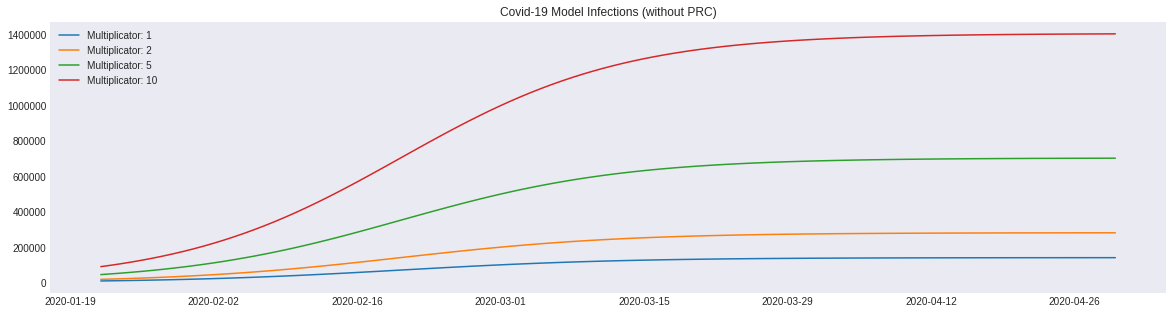

In [114]:
rg = np.array(range(100))
dr1 = pd.date_range(df.index[0], periods=100)
dr2 = pd.date_range(df.index[0], periods=len(df.index))
#plt.scatter(dr2, y_data, label='Confirmed Cases')
for variance in var_dict.keys():
    fit_params = var_dict[variance]
    plt.plot(dr1, logistic(rg, *fit_params), label='Multiplicator: {}'.format(round(variance, 2)))
plt.legend(loc='best')
plt.title('Covid-19 Model Infections (without PRC)')

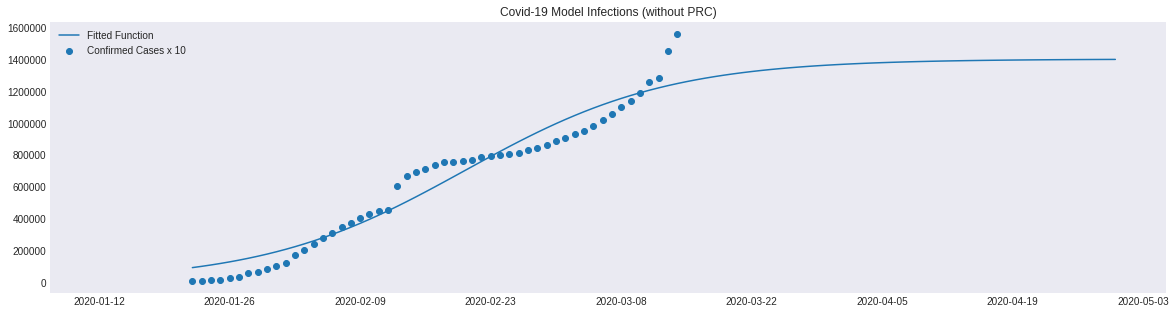

In [115]:
rg = np.array(range(100))
dr1 = pd.date_range(df.index[0], periods=100)
dr2 = pd.date_range(df.index[0], periods=len(df.index))
plt.scatter(dr2, y_data*10, label='Confirmed Cases x 10')
fit_params = var_dict[10]
plt.plot(dr1, logistic(rg, *fit_params), label='Fitted Function')
plt.legend(loc='best')
plt.title('Covid-19 Model Infections (without PRC)')